<hr>
<center><h2>Image Analysis</h2></center>
<hr>

## 1. Loading the data


Importing all necessaray packages, loading the dataand creating session

In [1]:
import torch
from PIL import Image
import io
import pandas as pd
import json
import random
import matplotlib as plt

In [2]:
import torchvision.transforms as transforms
from torchvision import models

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import cast, lit

Creating spark session

In [4]:
spark = SparkSession.builder \
    .appName("ImageNetClassification") \
    .config("spark.driver.memory", "3g")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/25 13:08:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/07/25 13:08:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## 2. Using the ResNet model for classification

In [5]:
model = models.resnet50(pretrained=True)
model.eval()

/Users/prabhatks/miniconda3/envs/image_caption/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/prabhatks/miniconda3/envs/image_caption/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
with open("../utils/imageNet_weights.json") as f:
    labels = json.load(f)

In [8]:
# creating windows for classifying images in that window 
def split_image(image, patch_size):
    width, height = image.size
    patches = []
    for i in range(0, width, patch_size):
        for j in range(0, height, patch_size):
            box = (i, j, i + patch_size, j + patch_size)
            patch = image.crop(box)
            patches.append(patch)
    return patches

In [9]:
def classify_image(image_path, patch_size=224):
    image = Image.open(image_path)
    patches = split_image(image, patch_size)
    results = []
    for patch in patches:
        patch = preprocess(patch)
        patch = patch.unsqueeze(0)

        with torch.no_grad():
            outputs = model(patch)
        _, predicted = outputs.max(1)
        label = labels[predicted.item()]
        if label not in results:
            results.append(label)
    return results

In [10]:
classify_image_udf = udf(classify_image, StringType())

In [11]:
caption_df = spark.read.csv("../archive/captions.txt", header=True)
caption_df.show(5, truncate=False)

+-------------------------+------------------------------------------------------------------------+
|image                    |caption                                                                 |
+-------------------------+------------------------------------------------------------------------+
|1000268201_693b08cb0e.jpg|A child in a pink dress is climbing up a set of stairs in an entry way .|
|1000268201_693b08cb0e.jpg|A girl going into a wooden building .                                   |
|1000268201_693b08cb0e.jpg|A little girl climbing into a wooden playhouse .                        |
|1000268201_693b08cb0e.jpg|A little girl climbing the stairs to her playhouse .                    |
|1000268201_693b08cb0e.jpg|A little girl in a pink dress going into a wooden cabin .               |
+-------------------------+------------------------------------------------------------------------+
only showing top 5 rows



In [12]:
df_sampled = caption_df.sample(fraction=0.1, seed=random.randint(0,100))
df_sampled.show()

+--------------------+--------------------+
|               image|             caption|
+--------------------+--------------------+
|1002674143_1b742a...|There is a girl w...|
|1002674143_1b742a...|Young girl with p...|
|1007320043_627395...|A small child gri...|
|1009434119_febe49...|A Boston terrier ...|
|1015584366_dfcec3...|A black dog leaps...|
|101669240_b2d3e7f...|A man skis past a...|
|1019077836_6fc9b1...|A brown dog chase...|
|1019077836_6fc9b1...|a brown dog plays...|
|1019604187_d087bf...|A white dog is ab...|
|1022454428_b6b660...|Couple with a bab...|
|102455176_5f8ead6...|A man uses ice pi...|
|1030985833_b0902e...|A brown and black...|
|1032122270_ea6f0b...|Three dogs on a g...|
|1032460886_4a598e...|There is a skyscr...|
|104136873_5b5d41b...|Three people hang...|
|1042020065_fb3d3b...|A boy in a green ...|
|1042590306_95dea0...|Asian man and blo...|
|1045521051_108ebc...|Someone is laying...|
|1053804096_ad278b...|a girl with pigta...|
|1056359656_662cee...|A little g

In [13]:
def get_full_path(image_name, image_dir):
    return image_dir + "/" + image_name

In [14]:
full_path_udf = udf(get_full_path, StringType())

In [15]:
df_sampled = df_sampled.withColumn("image_path", full_path_udf(df_sampled["image"], lit("../archive/Images")))
df_sampled.show()

+--------------------+--------------------+--------------------+
|               image|             caption|          image_path|
+--------------------+--------------------+--------------------+
|1002674143_1b742a...|There is a girl w...|../archive/Images...|
|1002674143_1b742a...|Young girl with p...|../archive/Images...|
|1007320043_627395...|A small child gri...|../archive/Images...|
|1009434119_febe49...|A Boston terrier ...|../archive/Images...|
|1015584366_dfcec3...|A black dog leaps...|../archive/Images...|
|101669240_b2d3e7f...|A man skis past a...|../archive/Images...|
|1019077836_6fc9b1...|A brown dog chase...|../archive/Images...|
|1019077836_6fc9b1...|a brown dog plays...|../archive/Images...|
|1019604187_d087bf...|A white dog is ab...|../archive/Images...|
|1022454428_b6b660...|Couple with a bab...|../archive/Images...|
|102455176_5f8ead6...|A man uses ice pi...|../archive/Images...|
|1030985833_b0902e...|A brown and black...|../archive/Images...|
|1032122270_ea6f0b...|Thr

In [16]:
classification_df = df_sampled.withColumn("classification", classify_image_udf(df_sampled["image_path"]))
classification_df.show(truncate=False)

+-------------------------+------------------------------------------------------------------------------------+-------------------------------------------+------------------------------------------------------------------------------------------+
|image                    |caption                                                                             |image_path                                 |classification                                                                            |
+-------------------------+------------------------------------------------------------------------------------+-------------------------------------------+------------------------------------------------------------------------------------------+
|1002674143_1b742ab4b8.jpg|There is a girl with pigtails sitting in front of a rainbow painting .              |../archive/Images/1002674143_1b742ab4b8.jpg|[parachute, bucket, umbrella, match, envelope]                                            |
|1002674

## 3. Evaluating the model


Caption: There is a girl with pigtails sitting in front of a rainbow painting ., 
Classification: [parachute, bucket, umbrella, match, envelope]


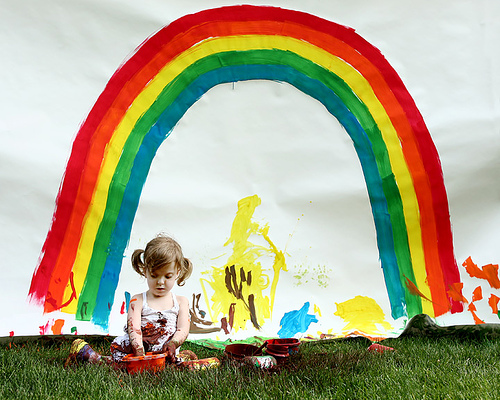

In [17]:
first_df = classification_df.first() 
img = Image.open(first_df["image_path"])
print(f"\nCaption: {first_df["caption"]}, \nClassification: {first_df["classification"]}")
img

## 4. Creating  the dataset

In [18]:
classification_df.show(10)

24/07/25 13:09:08 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+--------------------+--------------------+--------------------+--------------------+
|               image|             caption|          image_path|      classification|
+--------------------+--------------------+--------------------+--------------------+
|1002674143_1b742a...|There is a girl w...|../archive/Images...|[parachute, bucke...|
|1002674143_1b742a...|Young girl with p...|../archive/Images...|[parachute, bucke...|
|1007320043_627395...|A small child gri...|../archive/Images...|       [swing, knot]|
|1009434119_febe49...|A Boston terrier ...|../archive/Images...|[picket fence, go...|
|1015584366_dfcec3...|A black dog leaps...|../archive/Images...|[macaque, boa con...|
|101669240_b2d3e7f...|A man skis past a...|../archive/Images...|[dog sled, shovel...|
|1019077836_6fc9b1...|A brown dog chase...|../archive/Images...|[birdhouse, Vizsl...|
|1019077836_6fc9b1...|a brown dog plays...|../archive/Images...|[birdhouse, Vizsl...|
|1019604187_d087bf...|A white dog is ab...|../archive/

In [19]:
usable_df = classification_df.toPandas()

In [20]:
usable_df.shape

(3983, 4)

In [21]:
usable_df.to_parquet(f"../output/data.parquet")

In [22]:
spark.stop()